In [132]:
import math
import torch
from torch.distributions.kl import kl_divergence as KL
from torch.distributions.normal import Normal as N

import matplotlib.pyplot as plt

torch.manual_seed(0)

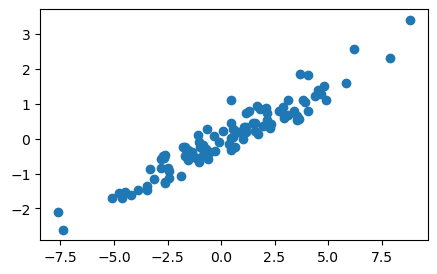

In [133]:
# generate some data
X = torch.randn(100, )
y = 3 * X + torch.randn(100, )

f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(y.numpy(), X.numpy(), 'o')

In [134]:
# define the objective function

def ELBO(mu, u, y, X, prior):
    sig = torch.exp(u) # ensure that sigma is positive

    # compute the expectation of the log likelihood
    ell = -0.5 * math.log(2 * math.pi * 1) - 0.5 * torch.sum(
            y**2 - 2 * y * X * mu + (X**2 * (mu**2 + sig**2))
        )
    
    # compute the KL between the VP and prior
    kl = KL(N(mu, sig), prior)

    return ell - kl

In [135]:
# define the prior and variational parameters
prior = N(0, 1)

mu = torch.randn(1, requires_grad=True)
u  = torch.randn(1, requires_grad=True)

iter: 0/100 		 loss: 927.77 	 mu: -0.99 	 sig: -0.10
iter: 25/100 		 loss: 188.63 	 mu: 1.33 	 sig: -1.66
iter: 50/100 		 loss: 52.71 	 mu: 2.69 	 sig: -2.03
iter: 75/100 		 loss: 51.02 	 mu: 2.96 	 sig: -2.14


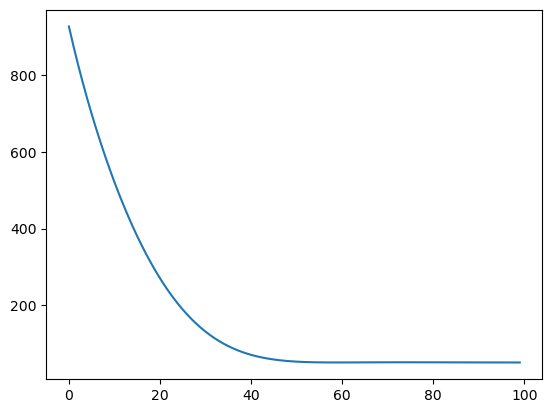

In [136]:
# optimize parameters
optimizer = torch.optim.Adam([mu, u], lr=0.1)
losses = []

for i in range(100):
    optimizer.zero_grad()
    loss = -ELBO(mu, u, y, X, prior)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if i % 25 == 0:
        print("iter: {}/{} \t\t loss: {:.2f} \t mu: {:.2f} \t sig: {:.2f}".format(
            i, 100, loss.item(), mu.item(), u.item()
        ))

plt.plot(losses)

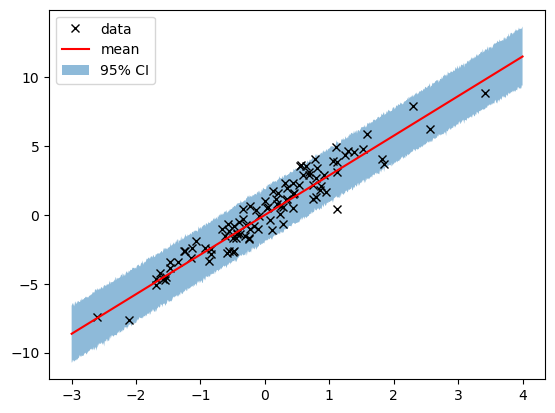

In [137]:
# plot the condidence interval
with torch.no_grad():
    sig = torch.exp(u)

    n_s = 750
    x = torch.linspace(-3, 4, n_s)

    y_pred =   mu * x

    plt.plot(X.numpy(), y.numpy(), 'x', color='k')
    plt.plot(x.numpy(), y_pred.numpy(), 'r')

    y_post_pred = N(mu, sig).sample((1000, )) * x + torch.randn(1000, n_s)
    y_l = y_post_pred.quantile(0.025, dim=0).detach().numpy()
    y_u = y_post_pred.quantile(0.975, dim=0).detach().numpy()
    plt.fill_between(x.numpy(), y_l, y_u, alpha=0.5)

    plt.legend(['data', 'mean', '95% CI'])